In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv('bad_samples.csv')

df.head(2)

C:\Users\Oren\AppData\Local\Temp\ipykernel_11672\4292204702.py:1: DtypeWarning: Columns (8,19,20,22,26,32,33,49,61,72,73,74,85,91,112,113,119,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('bad_samples.csv')


,Access_Mask,Access_Reasons,Accesses,Account_Domain,Account_Name,Additional_Data,Additional_Information,Advanced_Options,Application_Name,Authentication_Package,...,punct,source,sourcetype,splunk_server,splunk_server_group,tag,tag::eventtype,timeendpos,timestartpos,title
0,NaN,NaN,NaN,CLIENT-PC\n-,Communication_LTD\n-,NaN,NaN,NaN,NaN,NaN,...,//_::_====-=___.===_=_==_____.\r\r_:\rt_:tt---...,WinEventLog:Security,WinEventLog:Security,SIEM,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,CLIENT-PC,Communication_LTD,NaN,NaN,NaN,NaN,NaN,...,//_::_====-=___.===_=__==____.\r\r:\rt_:tt----...,WinEventLog:Security,WinEventLog:Security,SIEM,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
LogName = []
Date = []
Time = []
ComputerName = []
SourceName = []
TaskCategory = []
EventType = []
Message = []
Keywords = []
OpCode = []
EventCode = []
Type = []
RecordNumber = []

for i in range(0,len(df)):
    current_log = df.iloc[i]['_raw']
    Date.append(current_log[0:10])
    Time.append(current_log[11:22])
    LogName.append(re.search('LogName=(.*)\n', current_log).group(1))
    ComputerName.append(re.search('ComputerName=(.*)\n', current_log).group(1))
    SourceName.append(re.search('SourceName=(.*)\n', current_log).group(1))
    TaskCategory.append(re.search('TaskCategory=(.*)\n', current_log).group(1))
    EventType.append(re.search('EventType=(.*)\n', current_log).group(1))
    Keywords.append(re.search('Keywords=(.*)\n', current_log).group(1))
    OpCode.append(re.search('OpCode=(.*)\n', current_log).group(1))
    EventCode.append(re.search('EventCode=(.*)\n', current_log).group(1))
    Type.append(re.search('Type=(.*)\n', current_log).group(1))
    RecordNumber.append(re.search('RecordNumber=(.*)\n', current_log).group(1))
    Message.append(re.search('Message=(.*)', current_log).group(1))

df_cleaned = pd.DataFrame({ 'LogName' : LogName,
                         'Date' : Date,
                         'Time' : Time,
                         'ComputerName' : ComputerName,
                         'SourceName' : SourceName,
                         'TaskCategory' : TaskCategory,
                         'EventType' : EventType,
                         'Keywords' : Keywords,
                         'OpCode' : OpCode,
                         'EventCode' : EventCode,
                         'Type' : Type,
                         'RecordNumber' : RecordNumber,
                         'Message' : Message })

df_cleaned.head(5)

,LogName,Date,Time,ComputerName,SourceName,TaskCategory,EventType,Keywords,OpCode,EventCode,Type,RecordNumber,Message
0,Security,08/26/2023,06:08:41 PM,CLIENT-PC,Microsoft Windows security auditing.,Process Creation,0,Audit Success,Info,4688,0,248577,A new process has been created.
1,Security,08/26/2023,06:08:41 PM,CLIENT-PC,Microsoft Windows security auditing.,Sensitive Privilege Use,0,Audit Failure,Info,4673,0,248578,A privileged service was called.
2,Security,08/26/2023,06:08:41 PM,CLIENT-PC,Microsoft Windows security auditing.,Handle Manipulation,0,Audit Success,Info,4690,0,248579,An attempt was made to duplicate a handle to a...
3,Security,08/26/2023,06:08:41 PM,CLIENT-PC,Microsoft Windows security auditing.,File System,0,Audit Success,Info,4658,0,248580,The handle to an object was closed.
4,Security,08/26/2023,06:08:41 PM,CLIENT-PC,Microsoft Windows security auditing.,File System,0,Audit Success,Info,4656,0,248581,A handle to an object was requested.


Let's fix some of the features types:

In [4]:
df_cleaned['EventType'] = df_cleaned['EventType'].astype(int)
df_cleaned['EventCode'] = df_cleaned['EventCode'].astype(int)
df_cleaned['Type'] = df_cleaned['Type'].astype(int)
df_cleaned['RecordNumber'] = df_cleaned['RecordNumber'].astype(int)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%m/%d/%Y')
df_cleaned['Time'] = pd.to_datetime(df_cleaned['Time'], format='%I:%M:%S %p').dt.time

df_cleaned.dtypes

LogName                 object
Date            datetime64[ns]
Time                    object
ComputerName            object
SourceName              object
TaskCategory            object
EventType                int32
Keywords                object
OpCode                  object
EventCode                int32
Type                     int32
RecordNumber             int32
Message                 object
dtype: object

Now let's explore what event codes were generated in this attack:

<Axes: xlabel='EventCode'>

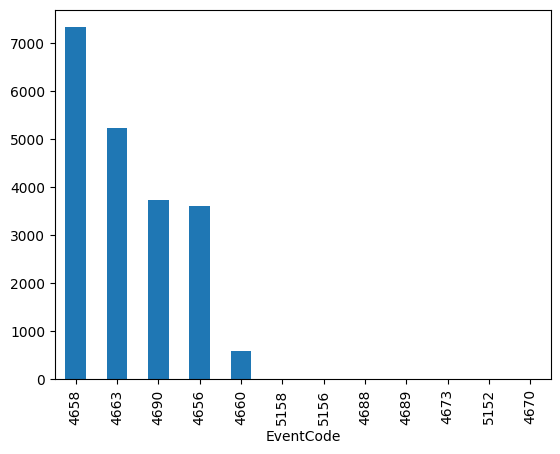

In [5]:
df['EventCode'].value_counts().plot.bar()

We can see that we have some logs here that doesn't appear as much as the others, hence they may be outliers for us.

#### <u>Removing Outliers</u>

1. We know that those logs were collected in a time when a malicious script was running (File encryptor).
2. Hence, by logic we can remove some of the logs that are not related to this attack.

First, let's check the messages, to see if they related to the attack:

In [6]:
value_counts = df_cleaned['EventCode'].value_counts()
outliers = [key for key, value in value_counts.items() if value < 50]

for event_code in outliers:
    print('EventCode ' + str(event_code) + ':', df_cleaned[df_cleaned['EventCode'] == event_code]['Message'].iloc[0])

EventCode 5158: The Windows Filtering Platform has permitted a bind to a local port.
EventCode 5156: The Windows Filtering Platform has permitted a connection.
EventCode 4688: A new process has been created.
EventCode 4689: A process has exited.
EventCode 4673: A privileged service was called.
EventCode 5152: The Windows Filtering Platform has blocked a packet.
EventCode 4670: Permissions on an object were changed.


We are certainly sure that we haven't made an intentional internet connection while we tested our encryption script.<br>
Therefore, from this perspective, event codes 5152, 5156, and 5158 are indeed outliers, so we can delete them:

In [7]:
print('Before dropping:', len(df_cleaned))
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 5152].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 5156].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 5158].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4688].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4689].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4673].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4670].index, inplace=True)
print('After dropping:', len(df_cleaned))

value_counts = df_cleaned['EventCode'].value_counts()
print('Values after drop:', value_counts)

Before dropping: 20502
After dropping: 20472
Values after drop: EventCode
4658    7325
4663    5237
4690    3724
4656    3601
4660     585
Name: count, dtype: int64


Let's see what logs we left with:

In [8]:
value_counts = df_cleaned['EventCode'].value_counts()

for pair in value_counts.items():
    print('EventCode ' + str(pair[0]) + ':', df_cleaned[df_cleaned['EventCode'] == pair[0]].iloc[0]['Message'])

EventCode 4658: The handle to an object was closed.
EventCode 4663: An attempt was made to access an object.
EventCode 4690: An attempt was made to duplicate a handle to an object.
EventCode 4656: A handle to an object was requested.
EventCode 4660: An object was deleted.


Now that we removed the outliers, we can save our data set as <b>'bad_samples_cleaned.csv'</b>:

In [9]:
df_cleaned.to_csv('bad_samples_cleaned.csv', index=False)